In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.1/910.1 kB 19.6 MB/s eta 0:00:0000:01


In [52]:
from ultralytics import YOLO
import os
import shutil
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def prepare_images(initial_training_dir):
    for character in ['dad', 'mom', 'dexter', 'deedee']:
        character_dir = os.path.join(initial_training_dir, character)
        for image in os.listdir(character_dir):
            image_path = os.path.join(character_dir, image)
            new_image_name = f'{character}_{image}'
            new_image_path = os.path.join('datasets', train_data_dir, 'images', new_image_name)
            if not os.path.exists(new_image_path):
                shutil.copy(image_path, new_image_path)

def convert_annotations(input_file, character, output_dir, images_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(input_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        img_name = parts[0]
        x_min, y_min, x_max, y_max = map(int, parts[1:5])
        label = parts[5]
        
        # print(img_name)
        img_name = f'{character}_{img_name}'
        # print(images_dir)
        # print(img_name)

        # YOLO format: class_id x_center y_center width height (normalized)
        img_path = os.path.join(images_dir, img_name)
        img_width, img_height = get_image_dimensions(img_path)

        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        class_id = label_to_class_id(label)

        label_file = os.path.join(output_dir, img_name.replace('.jpg', '.txt'))
        with open(label_file, "a") as label_f:
            label_f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def label_to_class_id(label):
    classes = {"dad": 0, "mom": 1, "dexter": 2, "deedee": 3, "unknown": 4}
    return classes[label]

def class_id_to_label(class_id):
    classes = {0: "dad", 1: "mom", 2: "dexter", 3: "deedee", 4: "unknown"}
    return classes[class_id]

def get_image_dimensions(image_path):
    img = cv.imread(image_path)
    return img.shape[1], img.shape[0]

def train_yolo(data_yaml, model='yolov8n', epochs=50):
    model = YOLO(model)
    model.train(data=data_yaml, epochs=epochs)

def test_yolo(model_path, test_images_dir, project, name, conf=0.25):
    model = YOLO(model_path)
    results = model.predict(source=test_images_dir, conf=conf, save=True, save_txt=True, save_conf=True, project=project, name=name)

In [68]:
class Parameters:
    def __init__(self):
        
        # kaggle
        self.base_dir = '/kaggle/input/cava-trainingdata'
        #self.base_dir = './'
        
        self.dir_train_examples = os.path.join(self.base_dir, 'antrenare')
        self.dir_test_examples = os.path.join(self.base_dir,'validare/validare')
        
        self.use_small_batch = False 
        self.path_annotations = os.path.join(self.base_dir, 'validare/task1_gt_validare.txt')
        
        self.path_annotations_characters = {'dad': None, 'mom': None, 'dexter': None, 'deedee': None}
        for character in ['dad', 'mom', 'dexter', 'deedee']:
            self.path_annotations_characters[character] = os.path.join(self.base_dir, f'validare/task2_{character}_gt_validare.txt')
        
        # kaggle
        self.dir_save_files = os.path.join('/kaggle/working/', 'salveazaFisiere')
        #self.dir_save_files = os.path.join('./', 'salveazaFisiere')
        
        
        if not os.path.exists(self.dir_save_files):
            os.makedirs(self.dir_save_files)
            print('directory created: {} '.format(self.dir_save_files))
        else:
            print('directory {} exists '.format(self.dir_save_files))

        # set the parameters
        # TODO: aici poate facem separat pentru fiecare personaj in parte
        self.dim_window = 36  # exemplele pozitive (fete de oameni cropate) au 36x36 pixeli
        self.dim_hog_cell = 6  # dimensiunea celulei
        self.overlap = 0.3
        self.number_positive_examples = 6713  # numarul exemplelor pozitive
        self.number_negative_examples = 10000  # numarul exemplelor negative
        self.has_annotations = False
        self.threshold = 0
        self.use_hard_mining = True  # (optional) antrenare cu exemple puternic negative
        self.use_flip_images = True  # adaugam imaginile cu fete oglindite

        self.characters = ['dad', 'mom', 'dexter', 'deedee', 'face']
        self.images_faces = {} # for each image, extract the identified faces - (x_min, y_min, x_max, y_max)
        self.characters_faces = {} # for each character, extract their identified faces and the image path
        self.character_aspect_ratio = {'dad': 0.85, 'mom': 0.90, 'dexter': 1.25, 'deedee': 1.45, 'face': 1, 'unknown': 1} # dif x / dif y = width / height
        # kaggle
        self.dir_hard_mining = os.path.join('/kaggle/working/', 'hard_mining')
        self.windows = ['vertical_rectangle', 'horizontal_rectangle', 'square']
        self.window_aspect_ratio = {'vertical_rectangle': -0.75, 'horizontal_rectangle': 1.5, 'square': 1}

        # kaggle
        self.final_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad'
        self.task1_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad/task1'
        self.task2_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad/task2'
        # self.final_save_dir = './yolo/351_Ciuperceanu_Vlad'
        # self.task2_save_dir = './yolo/351_Ciuperceanu_Vlad/task2'
        # self.task1_save_dir = './yolo/351_Ciuperceanu_Vlad/task1'
        if not os.path.exists(self.final_save_dir):
            os.makedirs(self.final_save_dir)
        if not os.path.exists(self.task1_save_dir):
            os.makedirs(self.task1_save_dir)
        if not os.path.exists(self.task2_save_dir):
            os.makedirs(self.task2_save_dir)
            
def compute_average_precision(rec, prec):
    # functie adaptata din 2010 Pascal VOC development kit
    m_rec = np.concatenate(([0], rec, [1]))
    m_pre = np.concatenate(([0], prec, [0]))
    for i in range(len(m_pre) - 1, -1, 1):
        m_pre[i] = max(m_pre[i], m_pre[i + 1])
    m_rec = np.array(m_rec)
    i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
    average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i]) # aria de sub curba, calc ca suma ariilor dreptunghiurilor
    return average_precision

def intersection_over_union(bbox_a, bbox_b):
    x_a = max(bbox_a[0], bbox_b[0])
    y_a = max(bbox_a[1], bbox_b[1])
    x_b = min(bbox_a[2], bbox_b[2])
    y_b = min(bbox_a[3], bbox_b[3])

    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

    box_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
    box_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

    if float(box_a_area + box_b_area - inter_area) == 0:
        print('Found division by zero!')
        print('Box a and box b', bbox_a, bbox_b)
        print('coord xa ya xb yb', x_a, y_a, x_b, y_b)
        print('inter area, box_a_area, box_b_area', inter_area, box_a_area, box_b_area)
        return 0.0

    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

def eval_detections(detections, scores, file_names, given_path_annotations, extra=''):
    ground_truth_file = np.loadtxt(given_path_annotations, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int32)
    print(given_path_annotations)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average precision %.3f' % average_precision)
    plt.savefig(os.path.join(params.dir_save_files, f'precizie_medie{extra}.png'))
    plt.show()
    
def save_task1(detections, scores, file_names, extra=''):
    np.save(os.path.join(params.task1_save_dir, f'detections_all_faces{extra}.npy'), detections, allow_pickle=True, fix_imports=True)
    np.save(os.path.join(params.task1_save_dir, f'scores_all_faces{extra}.npy'), scores, allow_pickle=True, fix_imports=True)
    np.save(os.path.join(params.task1_save_dir, f'file_names_all_faces{extra}.npy'), file_names, allow_pickle=True, fix_imports=True)

def save_task2(character_detections, character_scores, character_file_names, character_predictions=None, extra=''):
    for character in params.characters:
        if character == 'face':
            continue
        np.save(os.path.join(params.task2_save_dir, f'detections_{character}{extra}.npy'), character_detections[character], allow_pickle=True, fix_imports=True)
        np.save(os.path.join(params.task2_save_dir, f'scores_{character}{extra}.npy'), character_scores[character], allow_pickle=True, fix_imports=True)
        np.save(os.path.join(params.task2_save_dir, f'file_names_{character}{extra}.npy'), character_file_names[character], allow_pickle=True, fix_imports=True)

        if character_predictions is not None:
            # save also txt with character predictions
            with open(os.path.join(params.dir_save_files, f'task2_predictions_{character}{extra}.txt'), 'w') as f:
                for prediction in character_predictions[character]:
                    f.write('%s %s %f\n' % (prediction[1], prediction[0], prediction[2]))

params: Parameters = Parameters()
params.overlap = 0.3

directory /kaggle/working/salveazaFisiere exists 


In [ ]:
if not os.path.exists('./datasets'):
    os.makedirs('./datasets')
    os.makedirs('./datasets/train')
    os.makedirs('./datasets/train/labels')
    os.makedirs('./datasets/train/images')
train_data_dir = "./train"
output_labels_dir = "./datasets/train/labels"
test_images_dir = params.dir_test_examples

prepare_images(params.dir_train_examples)
for character in ['dad', 'mom', 'dexter', 'deedee']:
    annotations_file = os.path.join(params.dir_train_examples, f'{character}_annotations.txt')
    convert_annotations(annotations_file, character, output_labels_dir, os.path.join('/kaggle/working/datasets', train_data_dir, 'images'))

In [24]:
data_yaml = "./yolo.yaml"
with open(data_yaml, "w") as yaml_file:
    yaml_file.write(f"""
        path: .
        train: {train_data_dir}
        val: {train_data_dir}
        test: {test_images_dir}
        nc: 5  # Number of classes
        names: ['dad', 'mom', 'dexter', 'deedee', 'unknown']
    """)

In [25]:
train_yolo(data_yaml)

Ultralytics 8.3.62 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 100MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:03<00:00, 1132.63it/s]


train: New cache created: /kaggle/working/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/datasets/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.17G      1.122       2.08      1.245         46        640: 100%|██████████| 250/250 [00:41<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:23<00:00,  5.25it/s]


                   all       4000       5813      0.839      0.758      0.821      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.2G      1.043      1.196      1.161         39        640: 100%|██████████| 250/250 [00:40<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


                   all       4000       5813      0.946      0.737      0.884      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.18G      1.037       0.99      1.151         45        640: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.07it/s]


                   all       4000       5813      0.874      0.856      0.898      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.17G       1.01     0.8708      1.136         53        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]


                   all       4000       5813      0.888      0.874       0.92      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.16G      1.002     0.7947      1.128         40        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


                   all       4000       5813      0.884      0.853      0.909      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.16G     0.9699     0.7186      1.117         44        640: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


                   all       4000       5813      0.905      0.892      0.932       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.16G     0.9583     0.6861      1.114         51        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


                   all       4000       5813      0.932      0.905      0.943       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.16G     0.9538     0.6654      1.103         47        640: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.18it/s]


                   all       4000       5813      0.943      0.917      0.959       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.16G     0.9412     0.6277      1.096         57        640: 100%|██████████| 250/250 [00:40<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.28it/s]


                   all       4000       5813      0.957      0.933      0.964      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.14G     0.9227     0.6049      1.091         49        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


                   all       4000       5813      0.955      0.936      0.967      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.16G     0.9179     0.5882      1.089         65        640: 100%|██████████| 250/250 [00:40<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]

                   all       4000       5813      0.961      0.929       0.97      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.16G     0.9184     0.5858      1.091         51        640: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


                   all       4000       5813      0.955      0.907      0.956      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.16G      0.901     0.5649      1.077         42        640: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


                   all       4000       5813      0.959      0.938      0.968      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.16G     0.8991     0.5452      1.075         39        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.12it/s]

                   all       4000       5813       0.96       0.95      0.974      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.16G     0.8828     0.5327      1.061         42        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.14it/s]

                   all       4000       5813      0.974      0.939      0.972      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.18G     0.8847     0.5311      1.067         34        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


                   all       4000       5813      0.964      0.938      0.971      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.14G     0.8958     0.5242      1.073         45        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]

                   all       4000       5813      0.974      0.958      0.982      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.14G      0.866     0.5132      1.056         41        640: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.21it/s]

                   all       4000       5813      0.968      0.969      0.984      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.16G     0.8638     0.4983      1.056         56        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]

                   all       4000       5813       0.97      0.971      0.983      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.16G      0.872      0.504      1.066         37        640: 100%|██████████| 250/250 [00:40<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


                   all       4000       5813       0.97      0.971      0.985      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.18G     0.8621     0.4895      1.057         48        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


                   all       4000       5813      0.973       0.97      0.985      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.16G      0.857     0.4852      1.051         49        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]

                   all       4000       5813      0.977      0.962      0.982      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.16G     0.8495     0.4729      1.054         49        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]

                   all       4000       5813      0.978      0.971      0.986      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.16G     0.8381     0.4702      1.049         55        640: 100%|██████████| 250/250 [00:40<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]

                   all       4000       5813      0.987       0.97      0.987       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.14G     0.8346      0.461      1.045         56        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]

                   all       4000       5813      0.988      0.973       0.99      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.16G     0.8304     0.4541      1.045         40        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


                   all       4000       5813      0.984      0.982       0.99      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.16G     0.8403     0.4464      1.047         41        640: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]

                   all       4000       5813      0.981       0.98      0.988      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.14G     0.8247     0.4459       1.04         37        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


                   all       4000       5813      0.986      0.978      0.989        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.16G     0.8183     0.4466      1.037         60        640: 100%|██████████| 250/250 [00:40<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.25it/s]

                   all       4000       5813      0.988       0.98      0.991      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.16G     0.8132     0.4276      1.035         32        640: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]

                   all       4000       5813      0.983      0.985      0.992      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.14G     0.8134     0.4263      1.031         49        640: 100%|██████████| 250/250 [00:40<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.25it/s]

                   all       4000       5813      0.986      0.981      0.991      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.16G     0.8066     0.4205      1.029         37        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.25it/s]

                   all       4000       5813      0.986      0.985      0.992      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.16G     0.7971     0.4149      1.024         42        640: 100%|██████████| 250/250 [00:40<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]

                   all       4000       5813      0.984      0.986      0.992      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.16G     0.7904     0.4136      1.022         57        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]

                   all       4000       5813      0.986      0.982      0.989      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.14G     0.7958     0.4099      1.024         44        640: 100%|██████████| 250/250 [00:40<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]

                   all       4000       5813      0.991      0.981      0.992      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.16G     0.7871     0.4079      1.016         51        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]

                   all       4000       5813      0.994      0.981      0.992      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.14G     0.7798     0.3969      1.017         53        640: 100%|██████████| 250/250 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]

                   all       4000       5813       0.99      0.986      0.993      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.16G     0.7803     0.3971      1.016         35        640: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]

                   all       4000       5813      0.995      0.985      0.993       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.18G     0.7791     0.3861      1.016         47        640: 100%|██████████| 250/250 [00:40<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]

                   all       4000       5813      0.992      0.986      0.993      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.16G     0.7724      0.389      1.011         45        640: 100%|██████████| 250/250 [00:40<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]

                   all       4000       5813      0.988      0.991      0.993      0.822


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.14G     0.7153     0.3131     0.9662         22        640: 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.28it/s]

                   all       4000       5813       0.99      0.991      0.993      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.14G     0.7083      0.306     0.9649         20        640: 100%|██████████| 250/250 [00:39<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]

                   all       4000       5813      0.994      0.988      0.993      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.14G     0.6998     0.3024     0.9624         24        640: 100%|██████████| 250/250 [00:39<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.19it/s]

                   all       4000       5813      0.993       0.99      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.16G      0.696     0.2958      0.954         21        640: 100%|██████████| 250/250 [00:39<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]

                   all       4000       5813      0.993      0.991      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.14G     0.6896     0.2948     0.9548         17        640: 100%|██████████| 250/250 [00:39<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]

                   all       4000       5813      0.993      0.993      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.14G     0.6835     0.2886     0.9497         23        640: 100%|██████████| 250/250 [00:39<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


                   all       4000       5813      0.993      0.992      0.994      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.15G     0.6765     0.2845     0.9449         23        640: 100%|██████████| 250/250 [00:39<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]

                   all       4000       5813      0.992      0.994      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.14G     0.6738     0.2844     0.9495         19        640: 100%|██████████| 250/250 [00:39<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]

                   all       4000       5813      0.994      0.993      0.994       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.14G     0.6686     0.2764     0.9432         20        640: 100%|██████████| 250/250 [00:39<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]

                   all       4000       5813      0.994      0.994      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.14G     0.6645     0.2736     0.9407         26        640: 100%|██████████| 250/250 [00:39<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:20<00:00,  6.25it/s]

                   all       4000       5813      0.994      0.994      0.994      0.843



50 epochs completed in 0.850 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.62 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:21<00:00,  5.79it/s]


                   all       4000       5813      0.994      0.994      0.994      0.843
                   dad       1282       1286      0.998          1      0.994      0.868
                   mom       1032       1033          1      0.998      0.995      0.805
                dexter       1847       1856      0.991      0.998      0.994      0.872
                deedee       1236       1244      0.998      0.993      0.994      0.865
               unknown        268        394      0.985      0.979      0.994      0.807


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


In [63]:
project = '/kaggle/working'
name = 'results'
test_yolo("/kaggle/working/runs/detect/train2/weights/best.pt", test_images_dir, project, name)


image 1/200 /kaggle/input/cava-trainingdata/validare/validare/001.jpg: 480x640 1 dad, 8.1ms
image 2/200 /kaggle/input/cava-trainingdata/validare/validare/002.jpg: 480x640 1 dad, 6.4ms
image 3/200 /kaggle/input/cava-trainingdata/validare/validare/003.jpg: 480x640 1 dexter, 6.1ms
image 4/200 /kaggle/input/cava-trainingdata/validare/validare/004.jpg: 480x640 1 dexter, 7 unknowns, 6.1ms
image 5/200 /kaggle/input/cava-trainingdata/validare/validare/005.jpg: 480x640 1 dexter, 1 unknown, 6.2ms
image 6/200 /kaggle/input/cava-trainingdata/validare/validare/006.jpg: 480x640 1 dexter, 1 unknown, 6.1ms
image 7/200 /kaggle/input/cava-trainingdata/validare/validare/007.jpg: 480x640 1 deedee, 6.1ms
image 8/200 /kaggle/input/cava-trainingdata/validare/validare/008.jpg: 480x640 1 dexter, 2 unknowns, 6.1ms
image 9/200 /kaggle/input/cava-trainingdata/validare/validare/009.jpg: 480x640 1 dexter, 6.1ms
image 10/200 /kaggle/input/cava-trainingdata/validare/validare/010.jpg: 480x640 1 deedee, 11.2ms
image 1

In [70]:
annotations_dir = os.path.join("/kaggle/working/results", 'labels')
conf = 0.25

detections = []
scores = []
file_names = []
classes = []

for file_name in os.listdir(annotations_dir):
    if file_name.endswith(".txt"):
        with open(os.path.join(annotations_dir, file_name), 'r') as f:
            lines = f.readlines()
            
            image_path = os.path.join(test_images_dir, file_name.replace('.txt', '.jpg'))
            img = cv.imread(image_path)
            img_width, img_height = img.shape[1], img.shape[0]
            
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                score = float(parts[5])
                
                if score >= conf:
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    x1 = (x_center - width / 2) * img_width
                    y1 = (y_center - height / 2) * img_height
                    x2 = (x_center + width / 2) * img_width
                    y2 = (y_center + height / 2) * img_height
                    
                    detections.append([x1, y1, x2, y2])
                    scores.append(score)
                    classes.append(class_id_to_label(class_id))
                    file_names.append(file_name.replace('.txt', '.jpg'))
                    
detections = np.array(detections)
scores = np.array(scores)
file_names = np.array(file_names)
classes = np.array(classes)

/kaggle/input/cava-trainingdata/validare/task1_gt_validare.txt


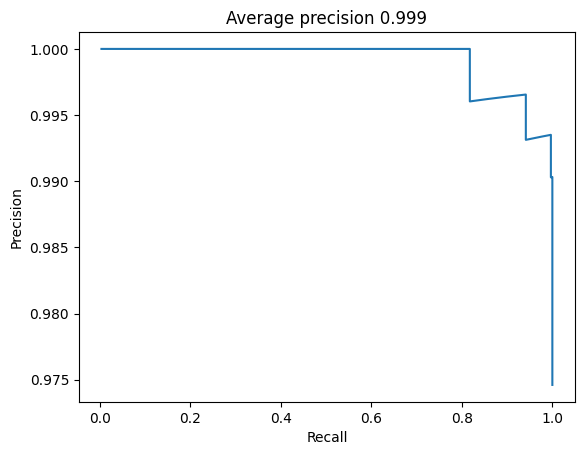

In [71]:
# task 1: detect all faces

save_task1(detections, scores, file_names)
params.use_small_batch = False
    
# only for validating, the code below should be commented
# for actual testing
eval_detections(detections, scores, file_names, params.path_annotations)

/kaggle/input/cava-trainingdata/validare/task2_dad_gt_validare.txt


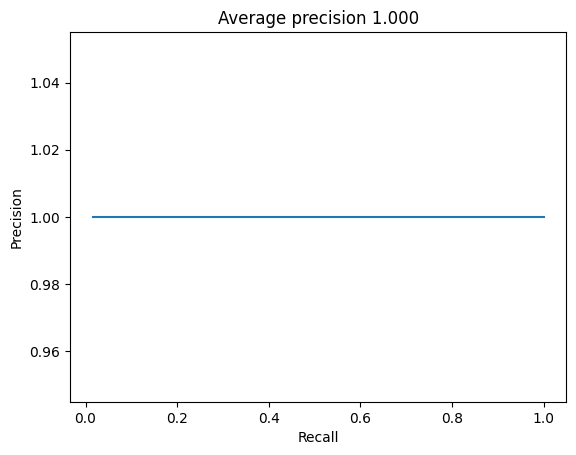

/kaggle/input/cava-trainingdata/validare/task2_mom_gt_validare.txt


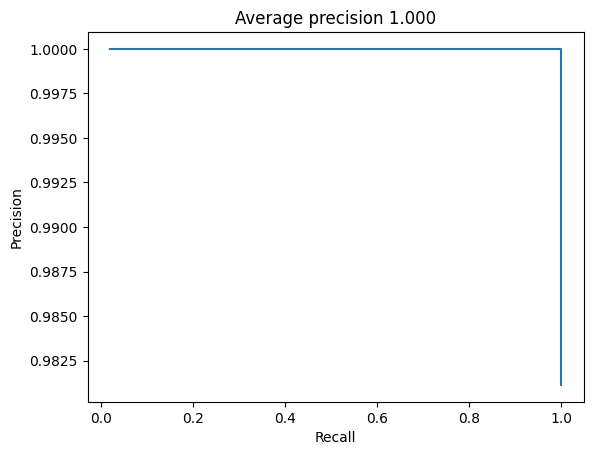

/kaggle/input/cava-trainingdata/validare/task2_dexter_gt_validare.txt


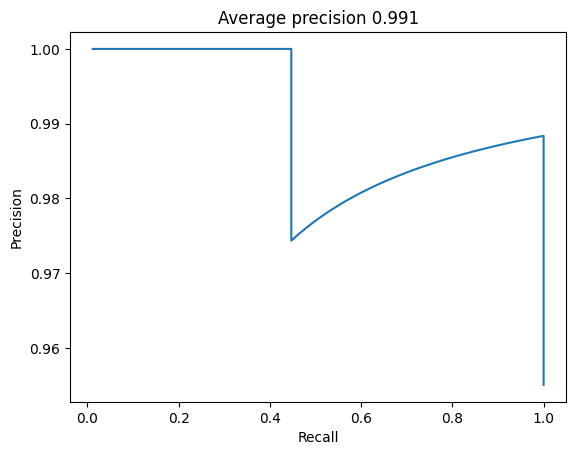

/kaggle/input/cava-trainingdata/validare/task2_deedee_gt_validare.txt


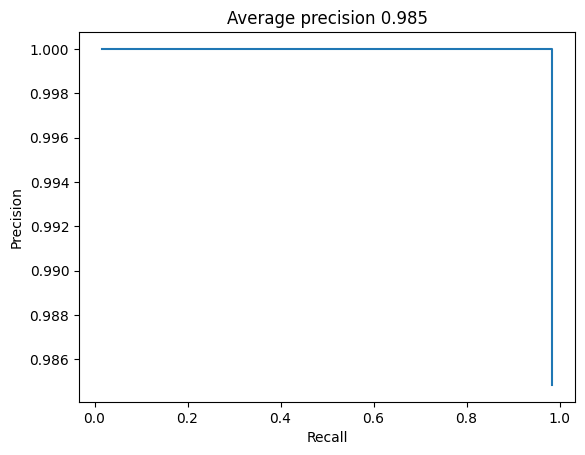

In [72]:
# task 2: detect characters

character_detections = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}
character_scores = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}
character_file_names = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}

for i, detection in enumerate(detections):
    if classes[i] in ['dad', 'mom', 'dexter', 'deedee']:
        character_detections[classes[i]].append(detection)
        character_scores[classes[i]].append(scores[i])
        character_file_names[classes[i]].append(file_names[i])

for character in ['dad', 'mom', 'dexter', 'deedee']:
    character_detections[character] = np.array(character_detections[character])
    character_scores[character] = np.array(character_scores[character])
    character_file_names[character] = np.array(character_file_names[character])
    
save_task2(character_detections, character_scores, character_file_names)

# only for validating, the code below should be commented
# for actual testing
for character in ['dad', 'mom', 'dexter', 'deedee']:
    eval_detections(character_detections[character], character_scores[character], character_file_names[character], params.path_annotations_characters[character], extra=f'_{character}')

In [73]:
# only in kaggle notebook
!zip -r /kaggle/working/after_training.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/results/ (stored 0%)
  adding: kaggle/working/results/019.jpg (deflated 5%)
  adding: kaggle/working/results/199.jpg (deflated 5%)
  adding: kaggle/working/results/131.jpg (deflated 4%)
  adding: kaggle/working/results/079.jpg (deflated 4%)
  adding: kaggle/working/results/081.jpg (deflated 4%)
  adding: kaggle/working/results/052.jpg (deflated 4%)
  adding: kaggle/working/results/191.jpg (deflated 4%)
  adding: kaggle/working/results/139.jpg (deflated 5%)
  adding: kaggle/working/results/009.jpg (deflated 4%)
  adding: kaggle/working/results/141.jpg (deflated 5%)
  adding: kaggle/working/results/003.jpg (deflated 5%)
  adding: kaggle/working/results/098.jpg (deflated 5%)
  adding: kaggle/working/results/166.jpg (deflated 3%)
  adding: kaggle/working/results/078.jpg (deflated 4%)
  adding: kaggle/working/results/099.jpg (deflated 4%)
  adding: kaggle/working/results/106.jpg (deflated 4%)
  adding: kaggle/working/results/011